In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [59]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
df = pd.read_csv("/Users/nikhi/Desktop/sentiment_analysis/twitter_Data/Twitter_Data.csv", encoding='ISO-8859-1')

In [62]:
# Data Cleaning
def preprocess_text(text):
    """
    Preprocess text by removing stopwords and keeping only alphabetic words
    
    Args:
        text (str): Input text to clean
    
    Returns:
        str: Cleaned text
    """
    # Tokenize the text
    tokens = word_tokenize(str(text).lower())
    
    # Remove stopwords and keep only alphabetic tokens
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    return ' '.join(cleaned_tokens)

In [63]:
# Clean the text column
df['clean_text'] = df['clean_text'].apply(preprocess_text)

In [64]:
df.head()

,clean_text,category
0,modi promised government maximum expected begi...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0


In [65]:
# Prepare features and labels
# Note: Your dataset uses -1, 0, 1 for categories
x = df['clean_text']
y = df['category']

In [66]:
# Convert labels to binary or multi-class based on unique values
unique_categories = y.unique()
if len(unique_categories) == 2:
    # Binary classification
    y = (y > 0).astype(int)  # Convert to 0 and 1
    classification_type = 'binary'
else:
    # Multi-class classification
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    classification_type = 'multi-class'

In [67]:
# Tokenization and Sequence Preparation
max_word = 20000
max_length = 200

tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_word)
tokenizer.fit_on_texts(x)

sequences = tokenizer.texts_to_sequences(x)
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)

In [68]:
# Model Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
training_portion = 0.7
BATCH_SIZE = 32

In [69]:
# Train-Test Split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    x, y, test_size=1-training_portion, random_state=42
)

In [70]:
# Define Model Architecture
# Adjust based on binary or multi-class
if classification_type == 'binary':
    output_activation = 'sigmoid'
    loss_function = 'binary_crossentropy'
    output_units = 1
else:
    output_activation = 'softmax'
    loss_function = 'sparse_categorical_crossentropy'
    output_units = len(np.unique(y))

model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)),
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(output_units, activation=output_activation)
])

model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │    12,782,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 196, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,873,156 (49.11 MB)

 Trainable params: 12,873,156 (49.11 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Training
num_epochs = 10
history = model.fit(
    train_sentences, train_labels, 
    epochs=num_epochs, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1
)

Epoch 1/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 225s 70ms/step - accuracy: 0.7979 - loss: 0.5132 - val_accuracy: 0.9132 - val_loss: 0.2809
Epoch 2/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 222s 69ms/step - accuracy: 0.9320 - loss: 0.2161 - val_accuracy: 0.9031 - val_loss: 0.2987
Epoch 3/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 223s 69ms/step - accuracy: 0.9674 - loss: 0.1046 - val_accuracy: 0.9025 - val_loss: 0.4024
Epoch 4/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 221s 69ms/step - accuracy: 0.9864 - loss: 0.0438 - val_accuracy: 0.8921 - val_loss: 0.5710
Epoch 5/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 222s 69ms/step - accuracy: 0.9926 - loss: 0.0239 - val_accuracy: 0.8950 - val_loss: 0.6373
Epoch 6/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 221s 69ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.8738 - val_loss: 0.6703
Epoch 7/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 231s 72ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.8837 - val_loss: 0.7977
Epoch 8/10
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 222s 69ms/step - accuracy: 

In [72]:
# Predictions
y_pred = model.predict(test_sentences)

1528/1528 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [73]:
# Convert predictions based on classification type
if classification_type == 'binary':
    y_pred_binary = (y_pred > 0.5).astype(int)
else:
    y_pred_binary = np.argmax(y_pred, axis=1)


In [74]:
# Evaluation
if classification_type == 'binary':
    class_names = ['Negative', 'Positive']
    report = classification_report(test_labels, y_pred_binary, target_names=class_names)
else:
    class_names = list(range(len(np.unique(y))))
    report = classification_report(test_labels, y_pred_binary, target_names=[str(c) for c in class_names])

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     10717
           1       0.91      0.93      0.92     16551
           2       0.90      0.89      0.89     21626
           3       0.00      0.00      0.00         1

    accuracy                           0.89     48895
   macro avg       0.66      0.66      0.66     48895
weighted avg       0.89      0.89      0.89     48895



C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

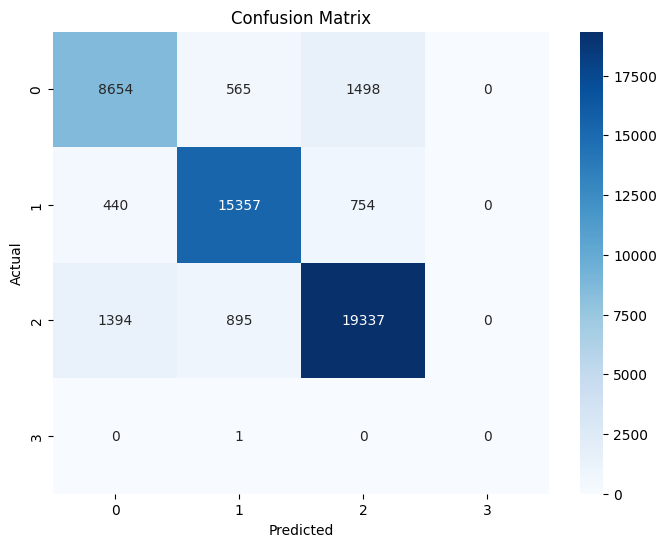

In [75]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

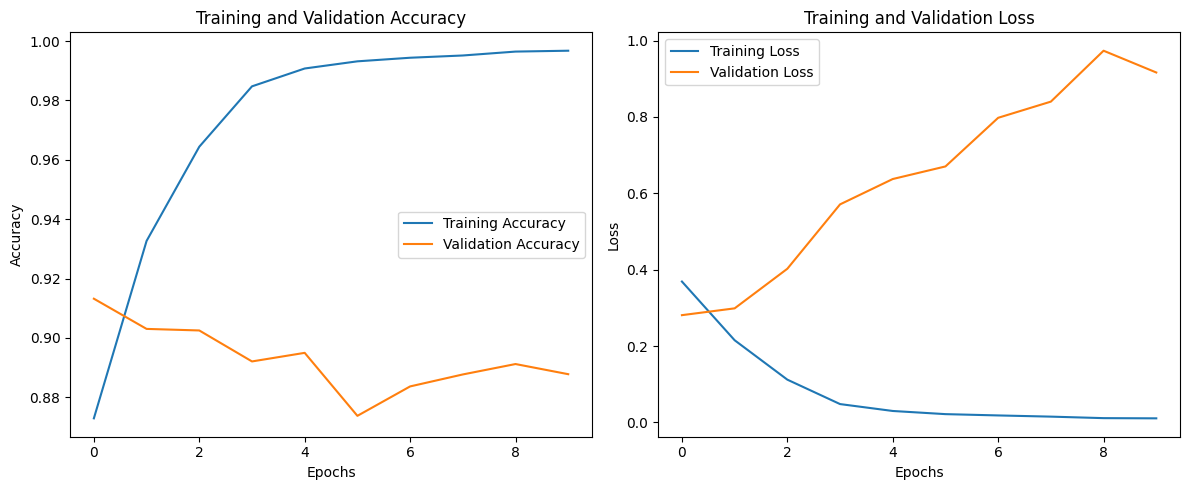

In [76]:
# Plotting Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
